<a href="https://colab.research.google.com/github/Afsah-Hyder/Computer-Vision-Course/blob/main/Copy_of_CV_Assignment_02_ah07065.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Computer Vision Assigment 02
## Name: Afsah Hyder
## ID: ah07065

In this question we will expand on your knowledge about Generative Adversarial Networks
(GANs). Building on top of what we have already implemented, the primary task in this question
is to implement a Deep Convolutional GAN (DCGAN).
You can read about GANs from online resources and understand it’s working principles. To get
an insight on the power of advanced GANs, check out this.
Simply speaking, a DCGAN is a type of GAN that uses a CNN as discriminator whereas for the
generator it uses an architecture similar to a CNN but instead of normal convolution layers, it is
composed of transposed convolutions. You can read more about DCGAN in the original
DCGAN paper.
To successfully complete the question, you need to complete all the parts below. Make sure to
cite all the sources used.
1. Load any one of the datasets from the list below, that you think is interesting to
work, on in your notebook (only the training dataset). We would recommend you
guys to downscale the images i.e., 64x64 or 32x32 and if needed, also convert
the image to greyscale. [5]
List of Datasets:
• Flowers
• Aircrafts
• Cute Dogs**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize
from torchvision.transforms import v2
from torch.nn import Sequential
import tensorflow as tf
import PIL
import PIL.Image
import tensorflow_datasets as tfds

**Loading the Dataset**

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

# Optional library for grayscale conversion
from PIL import Image  # If you choose to convert to grayscale

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')


228813984/228813984 [==============================] - 4s 0us/step


I also tried uploading the zip file of the dataset and unzipping it, however because of the subfolders, this didn't work as expected.

In [3]:
image_size=64

# Create the dataset
transformer=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

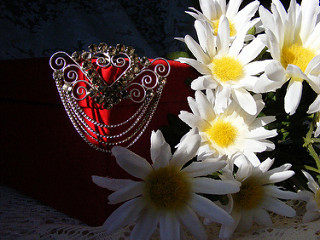

In [4]:
import PIL
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[9]))

In [5]:
# creating the test and train set
from torch.utils.data import DataLoader


batch_size = 16                               #smaller batch size selected bcs small dataset
img_height = 64
img_width = 64


train_set = torchvision.datasets.ImageFolder(root=data_dir, transform=transformer)

# Since there's no explicit test set, you can split the train set into train and test
train_size = int(0.8 * len(train_set))  # 80-20 split
test_size = len(train_set) - train_size
train_set, test_set = torch.utils.data.random_split(train_set, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

sample_image, sample_label = train_set[0]
print(sample_image.shape)

class_names = train_set.dataset.classes
print(class_names)

torch.Size([3, 64, 64])
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


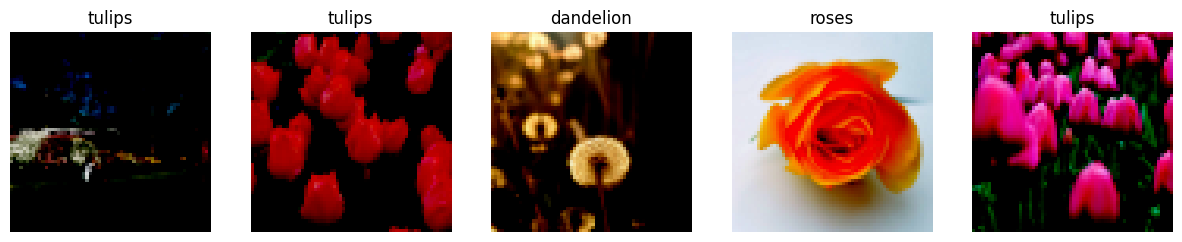

In [6]:
# viewing a few images from the train set
import matplotlib.pyplot as plt

# Function to display images from the dataset
def show_images(images, labels, class_names, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # permute to (height, width, channels) for displaying with matplotlib
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.show()

# Extract a batch of images and labels from the train_loader
for batch in train_loader:
    images, labels = batch
    break

# Display a few images from the batch
show_images(images, labels, class_names)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

HELP TAKEN FROM HERE: "https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html"

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

 **Implement a CNN based discriminator. Justify in no more than 2 lines why have you
chosen your architecture for the discriminator. Remember to use only Pytorch in
building your networks. [12+3]**

In [ ]:
# Size of feature maps in discriminator / size of feature maps in generator
nfm = 64

# Number of training epochs
num_epochs = 10


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(3, nfm, 4, 2, 1, bias=False),    #3 channels (RGB images)
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(nfm) x 32 x 32``
            nn.Conv2d(nfm, nfm * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfm * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(nfm*2) x 16 x 16``
            nn.Conv2d(nfm * 2, nfm * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfm * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(nfm*4) x 8 x 8``
            nn.Conv2d(nfm * 4, nfm * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfm * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(nfm*8) x 4 x 4``
            # nn.Conv2d(nfm * 8, nfm * 16, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nfm * 16),
            # nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(nfm*16) x 4 x 4``
            nn.Conv2d(nfm * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


**Why this architecture?** The CNN-based discriminator is chosen because it's good at recognizing spatial details in images. With convolutional layers, it can pick up on these details from the input image's RGB channels. This helps the discriminator tell apart real images from fake ones by looking for realistic patterns in the image's layout.



**Implement a generator that starts with a noise vector and generates an image from it.
Also, can we change the dimension of the starting vector? What effect would it have on
the result of your generator (research and write your best guess, you will be evaluated
for your thought process) [12+3]**

In [8]:
import torch
import torch.nn as nn

# Generator Code
sgi = 60   # size of generator input
nfm=64     # number of feature maps in the convolution process

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( sgi, nfm * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nfm * 8),
            nn.ReLU(True),
            # state size. ``(nfm*16) x 4 x 4``
            # nn.ConvTranspose2d(nfm * 16, nfm * 8, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nfm * 8),
            # nn.ReLU(True),
            # state size. ``(nfm*8) x 4 x 4``
            nn.ConvTranspose2d(nfm * 8, nfm * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfm * 4),
            nn.ReLU(True),
            # state size. ``(nfm*4) x 8 x 8``
            nn.ConvTranspose2d( nfm * 4, nfm * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfm * 2),
            nn.ReLU(True),
            # state size. ``(nfm*2) x 16 x 16``
            nn.ConvTranspose2d( nfm * 2, nfm, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfm),
            nn.ReLU(True),
            # state size. ``(nfm) x 32 x 32``
            nn.ConvTranspose2d( nfm, 3, 4, 2, 1, bias=False),    #3 is number of channels in the output image (we need RGB images)
            nn.Tanh()
            # state size. ``(3) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


The input to the generator is a z-dimensional vector of completely random values. In case of DCGAN, the input is from gaussian distribution source. GANs' theory is based on the fact that these random values are learnt to be distotred by the network in such a way that Discriminator is fooled by the image that is produced by the generator.

The dimensionality (size) of the noise vector plays a critical role, it influences the level of detail and control the GAN has over the generated image. A higher dimension, means more randomness, allows for greater creative freedom and diverse outputs. However, it can also lead to less control over the image's specific details. On the other hand, a lower-dimensional noise vector offers more control and focused generation, but potentially limits creativity and variation in the produced images.

SO the choice of noise vector dimension is a trade-off between achieving creative, diverse outputs and maintaining control over the generated image's details.

**Write the complete training loop for your GAN. Run it for 50 epochs or less, with a batch
size of your liking. You can run it for more epochs, just that it would take painfully long.
Your hyperparameters should be mentioned in a way that they are immediately visible.
[10]**

In [ ]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
ngpu = 1

# Create the generator
netG = Generator(ngpu).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(60, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, sgi, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs=35
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, sgi, 1, 1, device=device)                  #2nd param was sgi
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f \ %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/35][0/184]	Loss_D: 1.4377	Loss_G: 6.6435	D(x): 0.5639	D(G(z)): 0.4654 \ 0.0018
[0/35][50/184]	Loss_D: 1.1051	Loss_G: 16.4424	D(x): 0.5571	D(G(z)): 0.0000 \ 0.0000
[0/35][100/184]	Loss_D: 0.6386	Loss_G: 6.9432	D(x): 0.8377	D(G(z)): 0.3161 \ 0.0017
[0/35][150/184]	Loss_D: 0.8830	Loss_G: 14.6779	D(x): 0.6519	D(G(z)): 0.0000 \ 0.0000
[1/35][0/184]	Loss_D: 0.3283	Loss_G: 5.6396	D(x): 0.8579	D(G(z)): 0.0881 \ 0.0040
[1/35][50/184]	Loss_D: 2.0132	Loss_G: 3.0650	D(x): 0.2502	D(G(z)): 0.0038 \ 0.0969
[1/35][100/184]	Loss_D: 0.2095	Loss_G: 6.8490	D(x): 0.9387	D(G(z)): 0.1062 \ 0.0016
[1/35][150/184]	Loss_D: 1.1343	Loss_G: 5.5462	D(x): 0.4614	D(G(z)): 0.0042 \ 0.0071
[2/35][0/184]	Loss_D: 3.6416	Loss_G: 8.0023	D(x): 0.9364	D(G(z)): 0.9392 \ 0.0008
[2/35][50/184]	Loss_D: 0.8160	Loss_G: 3.0202	D(x): 0.6054	D(G(z)): 0.1221 \ 0.1320
[2/35][100/184]	Loss_D: 0.6706	Loss_G: 3.0987	D(x): 0.7428	D(G(z)): 0.1758 \ 0.0764
[2/35][150/184]	Loss_D: 0.8822	Loss_G: 3.2017	D(x): 0.718

**Determine your generator and discriminator losses in training. Plotting them would be a
nice practice [5]**

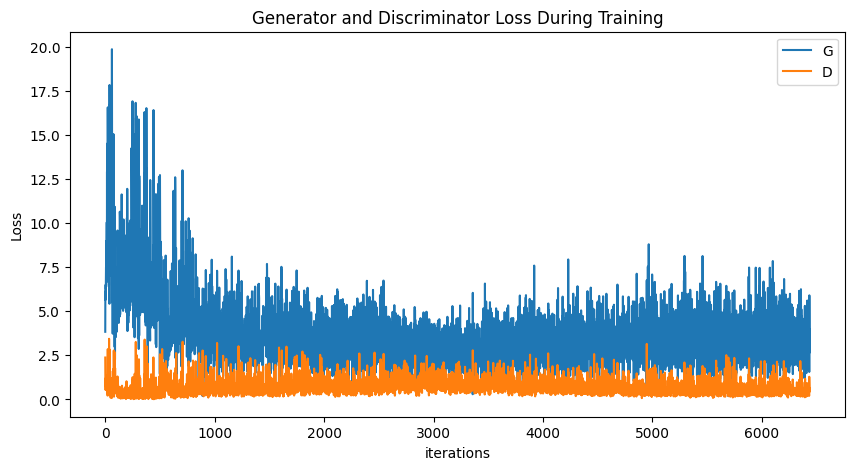

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Write a function named “generate_samples” which takes a single argument “n”. This
function will return “n” images generated using the trained generator. Use this function to
generate and display 20 images. [5]**

HTML(value='\n<link rel="stylesheet"\nhref="https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/css/font-awesom…

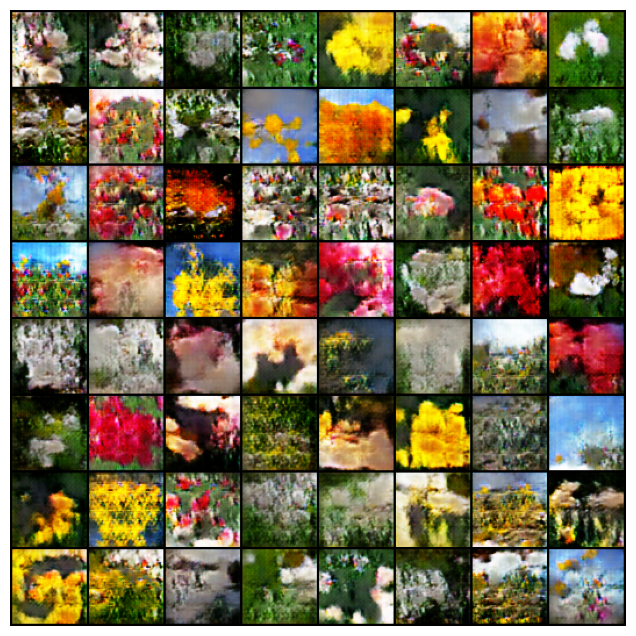

In [ ]:
# generate samples

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from ipywidgets import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**This part requires you to go back to the transfer learning idea that was introduced inAssignment 1. \\
a) Can we use a pre-trained VGG-16 network for this GAN? Would the resulting
network still be a DCGAN? [5]**

Yes, we can use a pre-trained VGG-16 network in your GAN. Specifically, it can be incorporated within the discriminator network. The VGG-16, trained on a massive image dataset, can learn high-level features that help the discriminator distinguish between real and generated images more effectively.

The resulting network wouldn't be a strict DCGAN (Deep Convolutional Generative Adversarial Network).


*   A DCGAN relies on specific convolutional neural network architectures for both the generator and discriminator. It prioritizes simplicity and uses transposed convolutions in the generator for image creation.
*   By introducing a pre-trained VGG-16 (which is not purely convolutional), our network becomes a variant of the base GAN architecture. It leverages the strengths of both approaches (pre-trained feature extraction and GAN architecture) for potentially better performance. shorten it a bit




---


**b) Since a GAN can essentially be thought of as two different networks that run-in
conjunction, a discriminator and a generator. What kind of network is VGG-16, is it
generative or discriminative? Why can it be not used for the other network? [5]**

VGG-16 is a CNN based classification algorithm. In GANs, this functionality is of the discriminator which classifies images into real or fake. So VGG-16 is discriminative.

VGG-16 is not suitable as a generator because it down-samples to extract features and then classifies based on those features. On the other hand, generator up-samples ot improve quality and generate hyper-realistic images from low-dimensional noise vector. There is also a functionality mismatch- generators in GANs aim to create new, realistic images based on random noise vectors. VGG-16, on the other hand, is trained to analyze and classify existing images.

---



**c) Change your GAN from the previous parts to incorporate VGG-16 in it and train it for a
single time only. Does it improve your results? You can argue based on generated
images and losses. [5]**

In [9]:
from torch.nn import functional as F
import torchvision.models as models

In [10]:
VGG_model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

# Freeze the parameters in VGG-16
for layer in VGG_model.features.parameters():
  layer.requires_grad = False

VGG_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


VGG_model.classifier[6] = nn.Linear(in_features=4096, out_features=1, bias=True)
VGG_model.classifier.add_module('7', nn.Sigmoid())
# this will classify, give probabilities and then less than 0.5: fake, and greater than 0.5: real

# def forward(self, x):
#   return self.features(x), self.avgpool(x), self.classifier(x.view(x.size(0), -1))
# Move model to device
VGG_model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 100MB/s]


cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, sgi, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(VGG_model.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
# same as before, the only thing different its VGG_model instead of netD


# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs=15
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        VGG_model.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = VGG_model(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, sgi, 1, 1, device=device)                  #2nd param was sgi
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = VGG_model(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = VGG_model(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f \ %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/184]	Loss_D: 0.3230	Loss_G: 5.5583	D(x): 0.7515	D(G(z)): 0.0308 \ 0.0050
[0/15][50/184]	Loss_D: 0.7800	Loss_G: 10.2611	D(x): 0.8015	D(G(z)): 0.3560 \ 0.0001
[0/15][100/184]	Loss_D: 0.8437	Loss_G: 9.4093	D(x): 0.8720	D(G(z)): 0.2871 \ 0.0002
[0/15][150/184]	Loss_D: 0.8967	Loss_G: 6.7715	D(x): 0.8868	D(G(z)): 0.1240 \ 0.0018
[1/15][0/184]	Loss_D: 0.4373	Loss_G: 4.9001	D(x): 0.9105	D(G(z)): 0.2432 \ 0.0095
[1/15][50/184]	Loss_D: 0.4654	Loss_G: 4.1661	D(x): 0.8984	D(G(z)): 0.0446 \ 0.0195
[1/15][100/184]	Loss_D: 0.3833	Loss_G: 4.1525	D(x): 0.8932	D(G(z)): 0.0583 \ 0.0197
[1/15][150/184]	Loss_D: 0.1081	Loss_G: 3.5114	D(x): 0.9616	D(G(z)): 0.0557 \ 0.0410
[2/15][0/184]	Loss_D: 0.4942	Loss_G: 4.3582	D(x): 0.9196	D(G(z)): 0.3125 \ 0.0188
[2/15][50/184]	Loss_D: 0.2677	Loss_G: 5.6470	D(x): 0.9926	D(G(z)): 0.2101 \ 0.0109
[2/15][100/184]	Loss_D: 0.5547	Loss_G: 4.2766	D(x): 0.8497	D(G(z)): 0.0121 \ 0.0198
[2/15][150/184]	Loss_D: 0.1247	Loss_G: 5.4224	D(x): 0.9645

KeyboardInterrupt: 

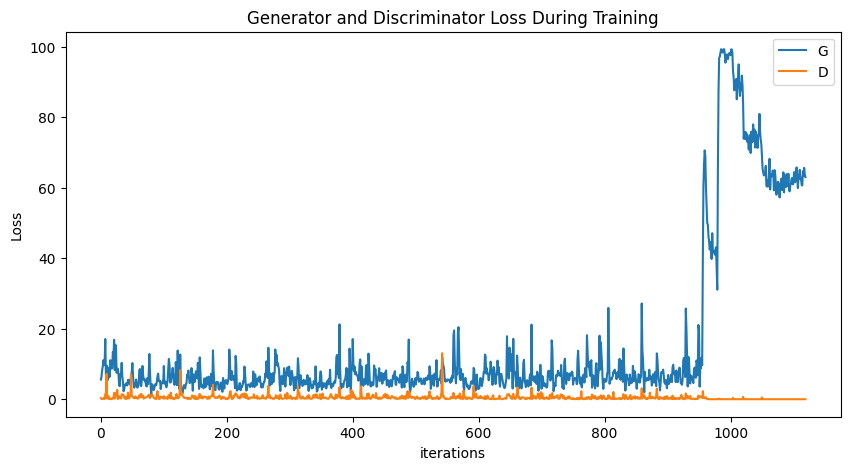

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

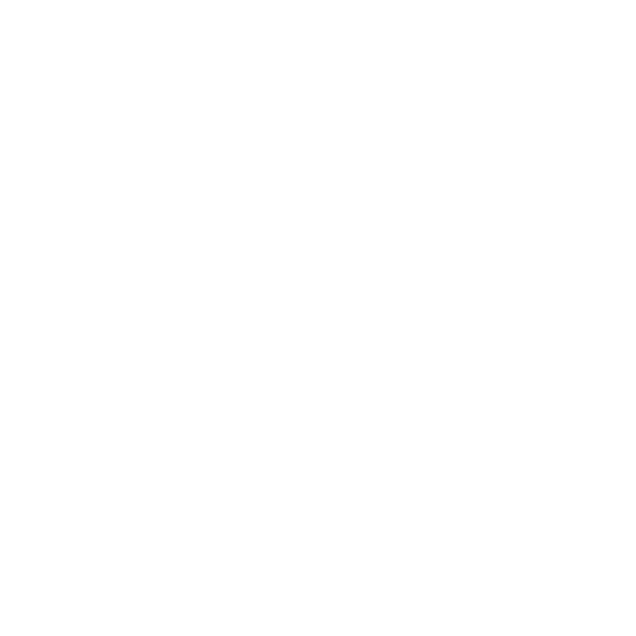

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

plt.show()
HTML(ani.to_jshtml())

This seems like a strange output, but others were also getting something similar.



---


**Question 02** In this question, you will have to read up a bit on the different types of GANS that are found:
Style transfer GAN, CGANS, CycleGAN, SRGANS. Only reading the abstract and introduction
of these papers will equip you to solve these questions, reading them fully is up to you. Then, go through the given situations and suggest the suitable GAN along with a short but
suitable explanation:



---


**a. A researcher gave a student the job to perform some preprocessing techniques on an image dataset. The student, while playing around with that data, applies a sufficiently large median blurring kernel to the images, but deletes the original files. These new images were padded correctly as to retain the original size of the images. Which GAN is best suited to revive the original HD images and why? [10]**

Super-Resolution Generative Adversarial Networks (SRGANs) are the most suitable architecture for restoring the missing detail in the blurred HD images. Unlike general-purpose GANs, SRGANs are specifically designed for super-resolution tasks. They excel at recovering the high-frequency details often lost due to blurring or downscaling in images. Their strength lies in a combined loss function that incorporates both an adversarial loss and a content loss.

**Adversarial Loss:**Similar to standard GANs, this loss encourages the generated images to appear realistic and indistinguishable from real HD photos. An adversarial network acts as a critic, continuously evaluating the SRGAN's outputs and pushing them towards replicating the visual characteristics of genuine high-resolution images.

**Content Loss:** This loss focuses on preserving the essential details and features present in the blurred versions. It ensures that the generated high-resolution images remain faithful to the content of the originals, even though the fine details were obscured by the blurring process. This targeted approach prevents the SRGAN from simply creating generic high-resolution images and instead guides it towards recovering the specific information lost during blurring.

By combining these two loss functions, SRGANs can not only produce visually realistic images but also retain the crucial content embedded within the blurred versions. This targeted approach makes SRGANs the most suitable architecture for restoring the missing details and reviving the original HD quality of the corrupted image dataset.



---


**b. Interns at a computer vision company are tasked with adding different skin textures to
images of pandas and regular bears. If presented with a picture of a regular bear, the
skin should be changed to match that of a panda. They do not have paired images of
pandas and bears that they can use as direct mappings of each other. They have a set
of images of pandas, and a different set of images of bears. Which GAN is best suited to
achieve this image-to-image translation task and why? [10]**

CycleGAN excels in unpaired image-to-image translation tasks. It utilizes two separate generators, one for transforming bears into panda-like images and another for transforming pandas into bear-like images. Crucially, CycleGAN enforces a "cycle consistency loss." This loss penalizes the generators if the "round trip" translation (bear to panda-like and back to bear) doesn't result in an image resembling the original bear. By leveraging unpaired data and enforcing cycle consistency, CycleGAN allows the interns to achieve realistic skin texture swapping on new bear images without the need for a paired dataset.

Furthermore, CycleGAN incorporates a discriminatory network that plays a critical role in the training process. This discriminator acts as an image critic, aiming to distinguish between real panda images and the panda-like images generated by G_panda (and vice versa for bears). By continuously evaluating the generated images, the discriminator helps refine G_panda and G_bear to produce increasingly realistic outputs that can fool the discriminator itself.

This combination of unpaired data utilization, cycle consistency loss, and adversarial training using a discriminator empowers CycleGAN to learn the underlying characteristics of each animal's skin texture. This knowledge allows CycleGAN to effectively translate unseen bear images into panda-like images, even without a direct point-to-point mapping between specific bears and pandas. This makes CycleGAN a valuable tool for various computer vision tasks beyond skin texture swapping, including photo style transfer, colorization of black and white images, and more.



---


**c. A daughter wants to give her Van Gogh-fanatic mother a present. So, she decides to
turna set of family photos to a set that looks as if it's been painted by Van Gogh. Which
GAN's best suited to achieve this task and how would she train her model (using what
datasets, etc.)? [10]**

Style Transfer GAN can create the painted photos with a Van Gogh artistic style. StyleGANs excel at transferring artistic style by learning from two key mechanisms.  Style vectors act like artistic fingerprints. They capture the essence of Van Gogh's style : the brushstrokes, colors, and textures, and encode them mathematically. This allows the StyleGAN to understand and replicate these artistic elements.

StyleGAN also employs a progressive training approach. Unlike traditional training on the entire dataset at once, StyleGAN starts by learning simpler versions of the images at lower resolutions. As the training progresses, the network complexity increases, and it gradually learns to generate higher-resolution images that incorporate the captured Van Gogh style. This step-by-step approach allows the StyleGAN to learn intricate details of the artistic style more effectively.

It also uses adaptive instance normalization to blent the artistic style with the actual content, which is the family photos in this case. The StyleGAN uses this method to adapt the learned Van Gogh style (captured in the style vectors) to the specific content of each family photo

Datasets needed: A collection of high-quality Van Gogh paintings and the family photos
